# Pyomo Mini-Project: Receding Horizon Stochastic Control

## Assignment Goals

The **primary purpose** of this assignment is to give you **hands-on-keyboard experience** with optimization modeling and analysis. In this assignment, I incorporated many of the best practices I share with my Ph.D. students during their first year using Pyomo for research. Specifically:
* Planning is the most important (and often most overlooked step) in computer programming. Two best practices are to (1) write pseudocode and (2) write the optimization model on paper and perform degree of freedom analysis before you use the computer. We practiced tip (2) in class. If you cannot do (1) and (2), no amount of Googling Pyomo/Python syntax will save you.
* Functions (or classes) allow us to reuse most of our code. Below I gave you function definitions and doc strings to show you a good way to "modularize" this analysis. Once the functions defined below work, performing the analysis is easy.
* Solving your optimization problem a few times is (often) not a sufficient research result. Who cares? Application-driven research is all about the analysis. Optimization is a tool to better answer analysis questions. By giving you >50% of the code for this assignment, I am intentionally emphasizing the analysis (not just coding).  You will see we can take a really simple optimization model and ask/answer some interesting analysis questions.

You should start this assignment early. Almost everyone will make at least one Python/Pyomo syntax mistake. Give yourself plenty of time to ask questions on Slack. Please also be generous with helping your classmates. This assignment (and grades in general in this class) is not a competition. You are welcome (encouraged!) to post screenshots of your code in Slack when asking/answering questions. Please refrain from posting your discussion responses. You are welcome to discuss the analysis questions on Slack; everyone should answer the discussion questions in their own words.

In [299]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.download_data(['Prices_DAM_ALTA2G_7_B1.csv'])

--2023-02-10 21:08:02--  https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6456 (6.3K) [text/plain]
Saving to: ‘helper.py.4’

helper.py.4         100%[===================>]   6.30K  --.-KB/s    in 0s      

2023-02-10 21:08:02 (68.5 MB/s) - ‘helper.py.4’ saved [6456/6456]

IDAES found! No need to install.
Ipopt found! No need to install.
ipopt was successfully installed
k_aug was successfully installed
Checking for ./data/Prices_DAM_ALTA2G_7_B1.csv
	File found!


In [300]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

In [301]:
ca_data = pd.read_csv('https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/Prices_DAM_ALTA2G_7_B1.csv',names=['price'])

In [302]:
def prepare_data_array(day=2,num_days=8):
    ''' Prepare numpy array of prices
    
    Arguments:
        day: day to start (0 = January 1, 2015)
        num_days: numbers of days to include in the vector
        
    Returns:
        numpy array of prices
    '''

    return ca_data["price"][(day)*24:24*(day+num_days)].to_numpy()

In the previous notebook, we considered model predictive control (MPC) of a battery energy storage system interacting with the electricity market. In essence, we posed an optimization problem:

*Given a forecasting for energy prices, what charging and discharging strategy maximizes net market revenue?*

In this homework mini-project, you will consider two modifications to make the example more realistic:
1. Add a constraint to prevent simultanous charging and discharging.
1. Receding horizon control
2. Uncertainty

The goal is to help you develop Python and Pyomo programming skills.

## Model Refinement and Code Reorganization

### Revised Model

Propose a new mathematical model that includes a constraint to prevent charging and discharging. Hint: using either integer variables or a disjunction will ensure the objective and constraints remaining linear.

Below is the model description copied from our in-class example. **Please edit** such that this notebook describes your complete new model.

**Sets**

Timesteps: $\mathcal{T} = \{0, 1, ..., N\}$
    
Timesteps without the initial time: $\mathcal{T}' = \{1, ..., N\}$

**Variables**
* $E_t$, energy stored in battery at time $t$, units: MWh
* $d_t$, battery discharge power (sold to market) during time interval [t-1, t), units: MW
* $c_t$, battery charge power (purchased from the market) during time interval [t-1, t), units: MW

**Parameters**
* $\pi_t$: Energy price during time interval [t-1, t), units: \$/MW
* $\eta$: Round trip efficiency, units: dimensionless
* $c_{max}$ Maximum charge power, units: MW
* $d_{max}$ Maximum discharge power, units: MW
* $E_{max}$ Maximum storage energy, units: MWh
* $E_{0}$ Energy in storage at time $t=0$, units: MWh
* $\Delta t = 1$ hour, Timestep for grid decisions and prices (fixed)

**Optimization Problem**

==========================================

!!! Here, I edit the code to include my solution using two different implementation

=========================================

$
\begin{align*}
    \max_{\mathbf{E},\mathbf{d},\mathbf{c}} \quad & \psi := \sum_{t \in \mathcal{T}'} \pi_{t} \Delta t (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + \Delta t \left( c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}} \right), ~~ \forall ~ t \in \mathcal{T}' \\
    & E_{0} = E_{N} \\
    & 0 \leq c_{t} \leq c_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq d_{t} \leq d_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \mathcal{T}'
\end{align*}
$

=========================================

**Answer :**

**Solution 1:**

**Disjunctive programming implementation**

$
\begin{align*}
\max_{\mathbf{E},\mathbf{d},\mathbf{c}} \quad & \psi := \sum_{t \in \mathcal{T}'} \pi_{t} \Delta t (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + \Delta t \left( c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}} \right), ~~ \forall ~ t \in \mathcal{T}' \\
& \\
&  \\
& \begin{bmatrix}
      d_{t} = 0, ~~\forall ~ t \in \mathcal{T}'
  \end{bmatrix}
  \veebar
  \begin{bmatrix}
  c_{t} = 0, ~~\forall ~ t \in \mathcal{T}'
  \end{bmatrix} \\
    & E_{0} = E_{N} \\
    & 0 \leq c_{t} \leq c_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq d_{t} \leq d_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \mathcal{T}'
\end{align*}
$

**Solution 2:**

**Big M implementation**
$
\begin{align*}
\max_{\mathbf{E},\mathbf{d},\mathbf{c}} \quad & \psi := \sum_{t \in \mathcal{T}'} \pi_{t} \Delta t (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + \Delta t \left( c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}} \right), ~~ \forall ~ t \in \mathcal{T}' \\
    & E_{0} = E_{N} \\
    & c_{t} \leq M y_{t}, ~~\forall ~ t \in \mathcal{T}' \\
    & d_{t} \leq M(1-y_{t}), ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq c_{t} \leq c_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq d_{t} \leq d_{max}, ~~\forall ~ t \in \mathcal{T}' \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \mathcal{T}'
\end{align*}
$

### Degree of Freedom Analysis

Perform degree of freedom analysis. Identify:
1. Total number of continous variables
2. Total number of integer variables (or disjunctions if using)
3. Total number of equality constraints
4. Total number of inequality constraints
5. Degrees of freedom

Tip: perform this on paper then typeset below.

===========================================

My Answers are based on the disjunctive model 
As I used it for the implementation

Also, here, $τ$ defines the length of the horizon

===========================================

**Answer :**


**Number of continous variables: $3×τ$**

**Number of integer variables: $2\timesτ$**

**Number of equality constraints: $1+τ$**  

**""$E_0 = E_N → 1$**

**$E_t → τ$**

**Number of inequality constraints: 0**
    
**Degrees of freedom:** 

Generally, the degree of freedom is defined by (The number of variables - The number of equality constraints), that in this case is $(4\tau - 1)$. But sometimes we need to include the inequality constraints that are active which can result that having a range for the degree of freedom (Active set)

### Python Code

Programmers organize their code into functions, often following the rule "1 task/action = 1 function". Here are a few of the reasons you should always do this:
1. Functions make your code easier to use
2. More specifically, functions force you to abstract/generalize your code
3. Writing doc strings (required for this course!) forces you to document your code and think about the structure.
4. Functions allow your code to best tested piece by piece

To show you how to do this, we have provided skeletons for several functions in this assignment. Based on the doc string, complete the functions.

In [303]:
def build_model(price_data, horizon_length, include_pbc, include_disjunction, e0=0):
    '''
    Builds HORIZON pyomo model
    
    Inputs:
    price_data: dictionary of price data
    horizon_length: number of timesteps to evaluate
    include_pbc: Boolean, include periodic boundary condition constraint
    
    Returns:
    m: HORIZON pyomo model
    '''
    
    m = pyo.ConcreteModel()
    
    # Add your solution here
          
    ## Define Sets
    # Number of timesteps in planning horizon
    m.N = horizon_length

    # Define the horizon set
    m.HORIZON = pyo.Set(initialize=range(1,m.N+1))

    ## Define Parameters
    # Square root of round trip efficiency
    m.sqrteta = pyo.Param(initialize = np.sqrt(0.88))

    # Energy in battery at t=0
    m.E0 = pyo.Param(initialize = e0, mutable=True)

    # Define Price as a parameter
    m.priceindex = pyo.Set(initialize=list(range(0, len(price_data))))
    m.price = pyo.Param(m.priceindex, initialize = price_data, mutable=True)

    ## Define variables    
    # Charging rate [MW]
    m.c = pyo.Var(m.HORIZON, initialize = 0.0, bounds=(0, 1), domain=pyo.NonNegativeReals)
    # Discharging rate [MW]
    m.d = pyo.Var(m.HORIZON, initialize = 0.0, bounds=(0, 1), domain=pyo.NonNegativeReals)
    # Energy (state-of-charge) [MWh]
    m.E = pyo.Var(m.HORIZON, initialize = 0.0, bounds=(0, 4), domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.maximize)
    def objfun(model):
      return  sum((-model.c[t] + model.d[t]) * model.price[t-1] for t in model.HORIZON)

    # Force Periodic Boundary Condition
    if include_pbc == True:
      m.PeriodicBoundaryCondition = pyo.Constraint(expr=m.E0 == m.E[m.N])

    # Energy Balance Constraint (Et)
    def EnergyBalance(model,t):
      # First timestep
      if t == 1 :
          return model.E[t] == model.E0 + model.c[t]*model.sqrteta-model.d[t]/model.sqrteta     
      # Subsequent timesteps
      else :
          return model.E[t] == model.E[t-1]+model.c[t]*model.sqrteta-model.d[t]/model.sqrteta

    m.EnergyBalance_Con = pyo.Constraint(m.HORIZON, rule = EnergyBalance) 

    # Add Disjunction Rule
    if include_disjunction == True:
      @m.Disjunction(m.HORIZON, xor=True)
      def ChargeDischarge(m, t):
        disjunct_1 = [m.d[t] == 0]
        disjunct_2 = [m.c[t] == 0]
        return [disjunct_1, disjunct_2]

      pyo.TransformationFactory("gdp.bigm").apply_to(m)

    # Solve the Model
    solver = pyo.SolverFactory('ipopt') 
    solver.options['max_iter'] = 50
    results = solver.solve(m)
    return m


In [304]:
# Here, I create a compile function in order to use further when I am updating 
def compile_model(m):
  solver = pyo.SolverFactory('ipopt') 
  solver.options['max_iter'] = 50
  results = solver.solve(m)
  return results

In [305]:
def extract_solution(m):
    '''
    Function to extract the solution from the solved pyomo model    
    Inputs:
        m: Solved pyomo model   
    Outputs:
        c_control: numpy array of charging power values, MW
        d_control: numpy array of discharging power values, MW
        E_control: numpy array of energy stored values, MWh
        t: numpy array of time indices from the Pyomo model, hr
    '''

    c_control = np.empty(pyo.value(m.N))
    d_control = np.empty(pyo.value(m.N))
    E_control = np.empty(pyo.value(m.N))
    t = np.empty(pyo.value(m.N))

    # Tip: We added a negative sign to d to help with plotting in the code discussed during class.
    # Add your solution here
    # Loop over elements of HORIZON set.
    for i in range(1, m.N+1):        
      t[i-1] = pyo.value(i)     
      c_control[i-1] = pyo.value(m.c[i])      
      # Adding negative sign to discharge for plotting
      d_control[i-1] = -pyo.value(m.d[i])
      E_control[i-1] = pyo.value(m.E[i])
    
    return c_control, d_control, E_control, t

In [306]:
def plot_solution(c, d, E, e0=2, t=None):
    '''
    Function to plot the solution of the HORIZON problem
    
    Inputs:
        c_control: numpy array of charging power values, MW
        d_control: numpy array of discharging power values, MW
        E_control: numpy array of energy stored values, MWh
        t: numpy array of time indices from the Pyomo model, hr. (default=None)
    
    Actions. Creates the following plots: 
        State of charge (energy) verus time
        Power to the grid verus time
    '''
    
    # Plot the state of charge (E)
    plt.figure()

    N = len(c)
    assert N > 0, "Input t must have length greate than 0"
    assert len(d) == N, "All inputs should be the same length"
    assert len(E) == N, "All inputs should be the same length"
    
    if t is None:
        # add E0
        t = np.array(range(1,N+1))
        t_ = np.array(range(0,N+1))
    else:
        t_ = np.concatenate(([0], t))
    # Add your solution here
    # Plot the state of charge (E)
    # add E0
    E_control_ = np.concatenate(([e0] , E))
    plt.plot(t_,E_control_,'b.-')
    plt.xlabel('Time (hr)')
    plt.ylabel('Energy in Storage (MWh)')
    plt.grid(True)
    plt.show()    
    # Plot charging/discharging plot
    plt.figure()
    # double up first data point to make the step plot
    c_control_ = np.concatenate(([c[0]] , c))
    d_control_ = np.concatenate(([d[0]] , d))
    plt.step(t_,c_control_,'r.-',where='pre')
    plt.step(t_,d_control_,'g.-',where='pre')
    plt.xlabel('Time (hr)')
    plt.ylabel('Power from Grid (MW)')
    plt.grid(True)
    plt.show()    
    return

### Optimal Control Over 3 Day Horizon

Now let's use our functions for some analysis. Calculate the optimal battery operation strategy over 3 days starting on January 4, 2015.

In [307]:
three_days = prepare_data_array(4,3)

#### Original Model

In [308]:
# Add your solution here
# !!! Here, I assume that E0 = 0
m_og = build_model(three_days, 3*24, include_pbc=True, include_disjunction=False, e0=0)
c_control_og, d_control_og, E_control_og, t_og = extract_solution(m_og)

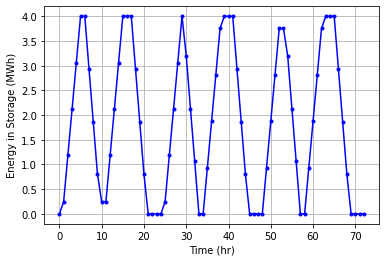

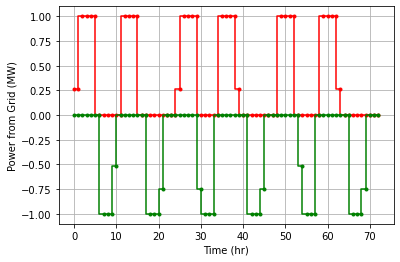

In [309]:
plot_solution(c_control_og, d_control_og, E_control_og, e0 = pyo.value(m_og.E0), t=t_og)

#### With Constraint Enforcing No Simultaneous Charging or Discharging

In [310]:
# Add your solution here
m_disj = build_model(three_days, 24 * 3, include_pbc=True, include_disjunction=True, e0=0)
c_control_disj, d_control_disj, E_control_disj, t_disj = extract_solution(m_disj)

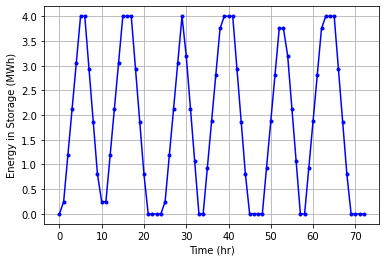

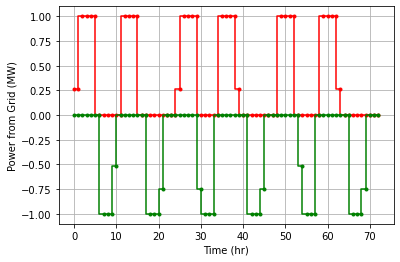

In [311]:
plot_solution(c_control_disj, d_control_disj, E_control_disj, e0 = pyo.value(m_disj.E0), t=t_disj)

#### Comparison

Write Python code below to compare the solutions. Print out any timesteps where the charge, discharge, and energy profiles are different by more than 10$^{-4}$ MW (or MWh).

In [312]:
def compare_solutions(solution1,solution2):
    '''
    Function to compare outputs between the original model and model with disjuncutions  
    Inputs:
    original: list of original charging/discharging data
    disjunction: list of disjunction model results charging/discharging data
    t: list of timesteps
    
    Action:
    prints same/different + timestep
    '''   
    assert len(solution1) == len(solution2), "solution 1 and solution2 must be the same length"
    
    n = len(solution1)
    # Add your solution here
    different_time_step = []
    differ_value = []
    for item in range(n):
      if solution1[item] - solution2[item] > 1e-4:
        different_time_step.append(item)
        differ_value.append(solution1[item] - solution2[item])
    if int(len(different_time_step)) == 0:
      print("Both solutions are the same")
    else:
      print("Solutions are different in some time steps")
      print("================================================\n")
      print("The timesteps the solutions are different are:\n")
      print(different_time_step)
      print("================================================\n")
      print("The different values in every timesteps are:\n")
      print(differ_value)
      print("================================================\n")
    print("Done.")

In [313]:
# Charge
compare_solutions(c_control_og, c_control_disj)

Both solutions are the same
Done.


In [314]:
# Discharge
compare_solutions(d_control_og, d_control_disj)

Both solutions are the same
Done.


In [315]:
# Energy
compare_solutions(E_control_og, E_control_disj)

Both solutions are the same
Done.


## Receding Horizon Control

We now have functions to build, solve, and analyze the battery problem for a single problem. Now we can consider receeding horizon control.

*Please ask questions during class. You do not need to turn anything in for this section.*

Nomenclature: Let $u^*_{i}$ represent the optimal control action from time $t=i$ to $t=i+1$. For the battery system, $u_{i} = [c_i, d_i]^{T}$ (charging and discharging).

Algorithm:
1. Consider time $t=m$. 
2. Compute the optimal control actions $u^*=[u^*_m, u^*_{m+1}, ..., u^*_{m+N-1}]^T$ from time $t=m$ until $t=N+m$ where $N$ is the length of the planning horizon. In our battery example, we considered $N = 24$.
3. Simulate the system for one timestep using control action $u^*_{m}$.
4. (Optional). Update the system model or forecasts using new observations.
5. Step $t=m+1$ and goto Step 2.

### Write Pseudocode

Pseudocode is an important planning tool for complex computer programs. The idea is to write out the code on paper or a whiteboard using generic programming syntax. As an example, consider calculating the 3rd through 10th elements of the Fibonacci sequence:

```
# Governing equation where f[i] is the ith element of the sequence
# f[i] = f[i-1] + f[i-2]

# Algorithm:

# Previous previous number in the sequence, f[i-2]
n_2prev = 1

# Previous number in the sequence, f[i-1]
n_1prev = 1

# Set counter
j = 3

while j <= 10 do:
    # Apply Fib. formula
    n = n1_prev + n2_prev
    
    # Print to screen
    print(n)
    
    # Shift history.
    # Previous number becomes previous previous number
    n2prev = n1prev
    
    # Current number becomes previous number
    n1prev = n
    
    # Increment counter
    j = j + 1
```

Here we sketched out the main algorithm (with comments!) in generic syntax. We did not worry about the correct way to write a while loop in Python. Once we figure out the algorithm we can worry about those details.

Write pseudocode for the receding horizon control example on paper or a whiteboard. Your algorithm should include the following main steps:
1. Load price data from a text file
2. Loop over timesteps. Keep track of implemented control actions (charge and discharge), battery SOC, and net revenue.
3. Make a plot of battery SOC and control actions that were actually implemented.

Scan your pseudocode as a PDF and turn in via Gradescope.

### Python Code

Tip: You should use the same `create_model` function throughout the assignment. In your model, define `price` to be a mutable parameter. This means we can just update the Pyomo model in the function below. We do not need to recreate it.

In [316]:
def update_model(model, new_price_data, new_E0):
    """ Update the Pyomo model with new price data
    
    Arguments:
        model: pyomo model
        new_price_data: numpy array or list containing price data
        new_E0: (float) value for initial battery charge
    """  
    # Add your solution here
    # As the model is indexed:
    for item in range(len(new_price_data)):
      model.price[item] = new_price_data[item]
    model.E0 = new_E0

In [317]:
def receding_horizon_simulation(price_data, simulation_length, num_hours, include_pbc_=True,verbose=True):  
    '''
    Perform receding horizon simulation
    
    Inputs:
        price_data: numpy array price data for entire time period of interest
        simulation_length: number of total hours to evaluate
        num_hours: horizon length for each optimization problem (N)
        include_pbc: boolean, include periodic boundary condition
        verbose: boolean, if true, print out message each hour
    
    Returns:
        c_control: charging decision implemented
        d_control: discharging decision implemented
        E_control: state-of-charge profile
        revenue_control: total revenue over simulation horizon
    
    '''
    
    # Check input data length
    assert len(price_data) >= simulation_length + num_hours, "Input price data is too short"
    
    assert simulation_length > 0, "Must evaluate more than 0 hrs"
    
    assert num_hours > 0, "Must consider planning horizon longer than 0 hrs"

    nS = simulation_length
    ## Preallocate vectors to store results
    # Here I am going to simulate the model for one time step (I choose the first index)
    c_control = np.empty(nS)
    d_control = np.empty(nS)
    E_control = np.empty(nS)
    revenue_control = np.empty(nS)
    # Add your solution here
    # Record SOC at end of time step
    e = 0
    ## Solve the problem in a receding horizon framework
    for item in range(nS): 
      # Prepare price data
      price_data_ = price_data[item:num_hours+item]
      # Either build or update model
      # Here I will build the first model and then update for further values
      if item == 0:
        model = build_model(price_data_, num_hours, include_pbc=include_pbc_, include_disjunction=True, e0=e)
      else: 
        # Updating the model 
        update_model(model, price_data_, e)
        # Solve the model
        compile_model(model)    
      # Record actual control strategy, update e
      (c_control_iter, d_control_iter, E_control_iter, t_iter) = extract_solution(model)
      c_control[item] = c_control_iter[0]
      d_control[item] = d_control_iter[0]
      revenue = (c_control_iter[0] + d_control_iter[0]) * price_data_[0]
      E_control[item] = E_control_iter[0]
      revenue_control[item] = revenue
      e = E_control_iter[0]
    return c_control, d_control, E_control, revenue_control

### Simulate Performance Over 3 Days

Perform receding horizon control for the first 3 days in January 2015. Make a plot to show the implemented control action.

Tips:
* The implemented control action is a concationation of the first timestep for each optimization problem.
* How can you resuse the plot function above?

In [318]:
three_days = prepare_data_array(0,4)

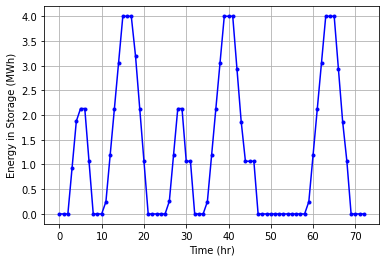

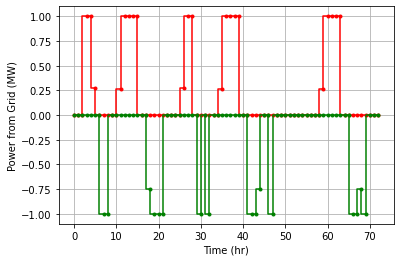

In [319]:
c_control_pbc, d_control_pbc, E_control_pbc, revenue_control_pbc = receding_horizon_simulation(three_days, 24*3, 
                                                                                24, include_pbc_=True,
                                                                                verbose=True)
plot_solution(c_control_pbc, d_control_pbc, E_control_pbc, e0=0)

### Impact of Horizon Length

Repeat the sensitivity analysis for horizon lengths of N=2 through N=48. For each simulation, compute the following:
1. Revenue from first 30 days
2. Total energy purchased from the market during the first 30 days
3. Total energy sold to the market during the first 30 days
4. Total computation time

In [320]:
# Study this cell to see how to time calculations in Python
import time

time_start = time.perf_counter()
first_month = prepare_data_array(0,34)
time_elapsed = (time.perf_counter() - time_start)

print("Elapsed Time",time_elapsed,"s")

Elapsed Time 0.0008149790010065772 s


In [321]:
rev = []
charge = []
discharge = []
timer = []

# Tip: This will take a few minutes to finish. While developing your solutions, 
# only simulate the first few values of N. This will be helpful if you need to
# restart your kernel and rerun the cells. Once you are happy with your code
# for the entire assignment, you can set N to the values given here then
# restart and run all.
N = [2, 4, 6, 8, 12, 24, 36, 48]
# Add your solution here
thirty_days = prepare_data_array(0,34)
for items in N:
  t1 = time.time()
  c_control_pbc, d_control_pbc, E_control_pbc, revenue_control_pbc = receding_horizon_simulation(thirty_days, 24*30, 
                                                                                items, include_pbc_=True,
                                                                                verbose=True)
  t2 = time.time()
  rev.append(np.sum(revenue_control_pbc))
  charge.append(np.sum(c_control_pbc))
  discharge.append(np.sum(d_control_pbc))
  timer.append((t2-t1))

Make four well labeled plots to show these trends.

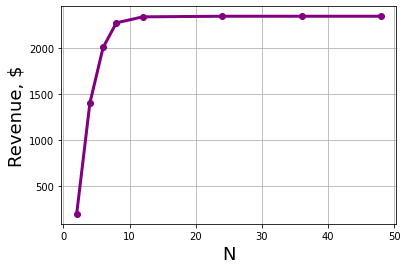

In [322]:
plt.plot(N,-1*np.array(rev),'o-',color="purple",linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Revenue, $',fontsize=18)
plt.grid(True)
plt.show()

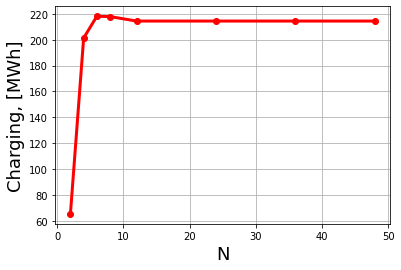

In [323]:
plt.plot(N,charge,'ro-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Charging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()

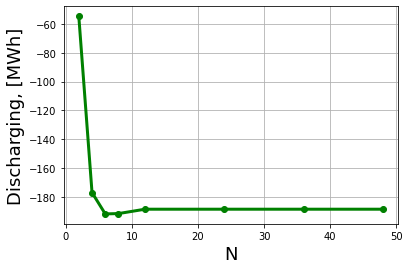

In [324]:
plt.plot(N,discharge,'go-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Discharging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()

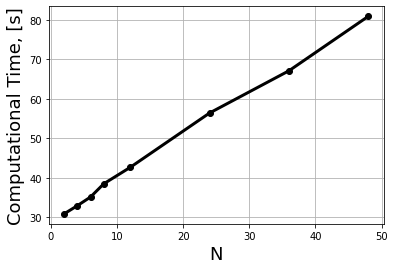

In [325]:
plt.plot(N,timer,'ko-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Computational Time, [s]',fontsize=18)
plt.grid(True)
plt.show()

**Discussion** How long of a simulation horizon do you recommend? Discuss the trade-off between revenue and computation time.

**Answer :**
As it is shown in the plot of revenue, after the horizon length of the 12, there is not specific change in the revenue, and the revenue has been converged to a specific value. On the other hand there is a gradual increase in the computational time which is completely predictable, because the number of the iterations increases.

Therefore, considering both computational efficiency and the converged value of the Revenue, the **Horizon with the length of 12** would recommended.

### Impact of Periodic Boundary Condition

We will now explore the impact of the periodic boundary constraint.

First, simulate the performance over 3 days **without enforcing the periodic boundary constraint**. Plot the implemented control action and calculate the total revenue. Use $N=4$.

In [326]:
c_control2, d_control2, E_control2, revenue_control2 = receding_horizon_simulation(three_days, 24*3, 4,
                                                                                  include_pbc_=False,verbose=True)

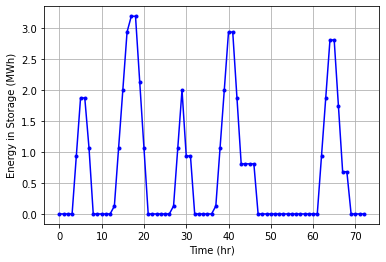

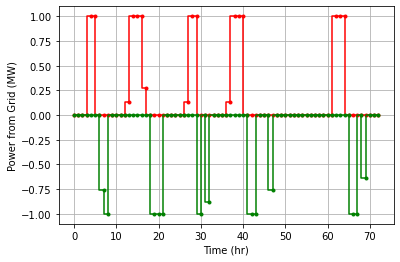

In [342]:
plot_solution(c_control2, d_control2, E_control2, e0=0)

Next, simulate **with the periodic boundary constraint** using $N=4$. Plot the results.

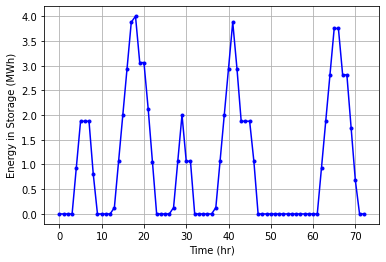

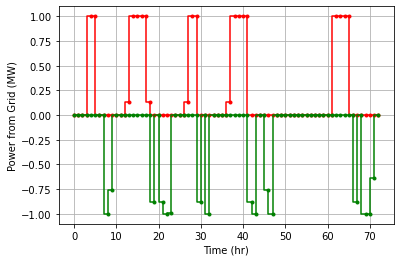

In [343]:
c_control3, d_control3, E_control3, revenue_control3 = receding_horizon_simulation(three_days, 24*3, 4,
                                                                                  include_pbc_=True,verbose=False)
plot_solution(c_control3, d_control3, E_control3, e0=0)

Now let's compare.

In [344]:
# Charge
compare_solutions(c_control2, c_control3)

Both solutions are the same
Done.


In [345]:
# Discharge
compare_solutions(d_control2, d_control3)

Solutions are different in some time steps

The timesteps the solutions are different are:

[8, 21, 22, 31, 45, 46, 68, 69, 70]

The different values in every timesteps are:

[0.7600000000839731, 0.9999999989218116, 0.9923325017764549, 0.11999999788157101, 0.7600000087461746, 0.2400000848272016, 0.35999996417667135, 0.9999999991990568, 0.640000003670945]

Done.


In [346]:
# Energy
compare_solutions(E_control2, E_control3)

Both solutions are the same
Done.


In [347]:
# Revenue
compare_solutions(revenue_control2, revenue_control3)

Solutions are different in some time steps

The timesteps the solutions are different are:

[8, 21, 22, 31, 45, 46, 68, 69, 70]

The different values in every timesteps are:

[26.660800002945773, 48.81599994736716, 46.3270428454338, 4.950119912612685, 33.480280385295224, 11.226963968131663, 17.66123824254332, 44.003999964755295, 26.588160152505736]

Done.


**Discussion** Compare the control actions and revenue with and without the periodic boundary constraint. How are they different (if at all)? Offer an explanation for any differences. (The purpose of this questions is to get you thinking about how to critically analyze the optimization results. This skill will be really important for the semester projects.)

============================================

**Answer :**

First, I think that enforcing the periodic boundary should affect the results and as it can be seen there are some points in the *discharge* plot, that are not same as the case that the periodic boundary has not applied (based on our sensitivity to differences $→ 10^{-4}$). This subsequently affects the *Revenue* and *Energy Storage*. In my opinion, enforcing the periodic boundary condition makes the results more realistic, specially in cases we are dependent on the numerical simulations like manufacturing process. 

Next, repeat the horizon length sensitivity analysis without the peridoic boundary constraint.

In [334]:
# Add your solution here
rev = []
charge = []
discharge = []
timer = []

# Tip: This will take a few minutes to finish. While developing your solutions, 
# only simulate the first few values of N. This will be helpful if you need to
# restart your kernel and rerun the cells. Once you are happy with your code
# for the entire assignment, you can set N to the values given here then
# restart and run all.
N = [2, 4, 6, 8, 12, 24, 36, 48]
thirty_days = prepare_data_array(0,34)
# Add your solution here
for items in N:
  t1 = time.time()
  c_control_pbc, d_control_pbc, E_control_pbc, revenue_control_pbc = receding_horizon_simulation(thirty_days, 24*30, 
                                                                                items, include_pbc_=False,
                                                                                verbose=True)
  t2 = time.time()
  rev.append(np.sum(revenue_control_pbc))
  charge.append(np.sum(c_control_pbc))
  discharge.append(np.sum(d_control_pbc))
  timer.append((t2-t1))

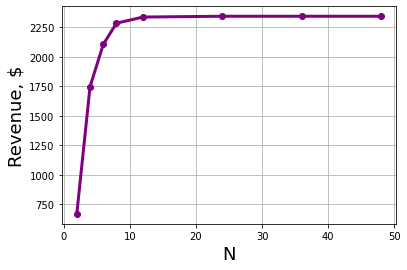

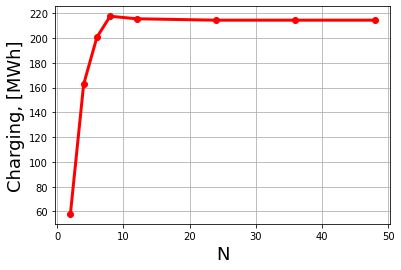

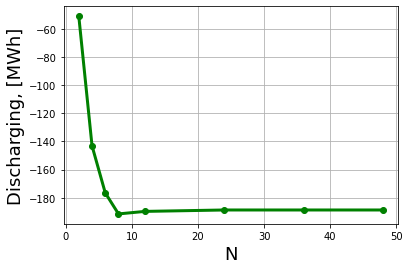

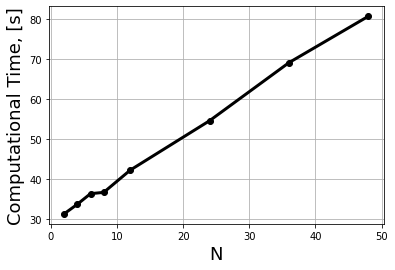

In [335]:
plt.plot(N,-1*np.array(rev),'o-',color="purple",linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Revenue, $',fontsize=18)
plt.grid(True)
plt.show()
#
plt.plot(N,charge,'ro-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Charging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()
#
plt.plot(N,discharge,'go-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Discharging, [MWh]',fontsize=18)
plt.grid(True)
plt.show()
#
plt.plot(N,timer,'ko-',linewidth=3)
plt.xlabel('N',fontsize=18)
plt.ylabel('Computational Time, [s]',fontsize=18)
plt.grid(True)
plt.show()

**Discussion** Compare these result to the analysis with periodic boundary constraints. Based on these results, make a recommendation to a battery operator.

========================================

**Answer :**

I think the plots are almost the same but from manufacturing view, I think paying attention to applying such system ($E_0 = E_{final}$) is of importance, as it guarantees the system have a specific storage level at the end of the horizons.

## Forecast Uncertainty (required for CBE 60499, optional for CBE 40499)

So far, we have assumed the battery operator can perfectly forecast the market price. This is not realistic. What is the impact of uncertainty?

Generate white noise with mean zero and standard deviation 5 \$/MWh using `np.random.normal()` and add this to the historical price. We will treat this as a price forecast. Simulate the first three days with $N=24$. Calculate how much less revenue you make with price uncertainty compared to the perfect information case. *Hint:* Each time you run the simulation, you will get a different answer. Repeat the analysis 10 times and record the average.

**Are you enrolled in CBE 60499** (are you a graduate student)? Please answer yes/no: **Yes**

In [336]:
revenue_unc_predicted = []
revenue_unc_actual = []
three_days = prepare_data_array(0,4)
# Perform simulation with perfect information
c_control, d_control, E_control, revenue_control = receding_horizon_simulation(three_days, 
                                                                                       24*3, 24, include_pbc_=True,
                                                                                  verbose=False)
# We can also calculate the revenue after the fact
rev_check = 0
for t in range(len(c_control)):
    # Why is this slightly different? In the instructor/TA solutions for receding_horizon_simulation,
    # we added a negative sign to d_control for plotting.
    rev_check -=  three_days[t]*(d_control[t] + c_control[t])

revenue_perfect_information = np.sum(revenue_control)
print("Revenue with perfect price forecast =", revenue_perfect_information,"=", rev_check,"$")

# Tip: normalize the revenue from the uncertain simulations by `revenue_perfect_information`
# This will make the interpretation much easier!

n = len(three_days)
nsim = 10
# !!!
# The scenario part is only for the noise -> calculate the revenue for the predicted price
# We then calculate it for the actual price
# !!!
for i in range(nsim):
    # Add random noise to data
    # Forcasted Price
    three_days_with_noise = three_days + 5*np.random.normal(size=n)
    c_predicted, d_predicted, E_predicted, revenue_predicted = receding_horizon_simulation(three_days_with_noise, 
                                                                                   24*3, 24, include_pbc_=True,
                                                                                   verbose=False)
    revenue_actual = sum((c_predicted[t] + d_predicted[t]) * three_days[t] for t in range(72))
    revenue_unc_predicted.append(revenue_predicted)
    revenue_unc_actual.append(revenue_actual)
    
print("Average Revenue =",np.mean(revenue_unc_actual)/revenue_perfect_information*100,"%")

Revenue with perfect price forecast = -263.8264101476798 = 263.8264101476798 $
Average Revenue = 72.67594946621121 %


**Discussion** Compare the results with your earlier analysis. How much less revenue do you get with Gaussian noise with standard deviation 5 $/MWh.

=========================================

**Answer :**

The ***average revenue*** that is normalized to the perfect value is equal to 73 % which shows almost 27 percent reduction. This result makes sense as the average calculated value is based on whole interval of the stochastic analysis. Providing more itereations may help the algorithm to converge to the ***Perfect Revenue Information***. Also, the random generation method that is utilized is based on the *Gaussian Distribution* with the mean of zero, so, noises that are added to the model can have the negative value too, which can result in the reduction in the average value.

Next, make a plot showing the average revenue as a function of the standard deviation of the uncertainty. *Hint*: Normalize the revenue by dividing by the perfect information revenue (no uncertainty).

In [337]:
# Add your solution here
standard_deviation = [0, 4, 8, 12, 16]
Revenue_Std = []
for std in standard_deviation:
  revenue_unc_predicted = []
  revenue_unc_actual = []
  for i in range(nsim):

      # Add random noise to data
      three_days_with_noise = three_days + std*np.random.normal(size=n)
      c_predicted, d_predicted, E_predicted, revenue_predicted = receding_horizon_simulation(three_days_with_noise, 
                                                                                   24*3, 24, include_pbc_=True,
                                                                                   verbose=False)
      # Add your solution here
      revenue_actual = sum((c_predicted[t] + d_predicted[t]) * three_days[t] for t in range(72))
      revenue_unc_predicted.append(revenue_predicted)
      revenue_unc_actual.append(revenue_actual)
  Revenue_Std.append(np.mean(revenue_unc_actual)/revenue_perfect_information*100)



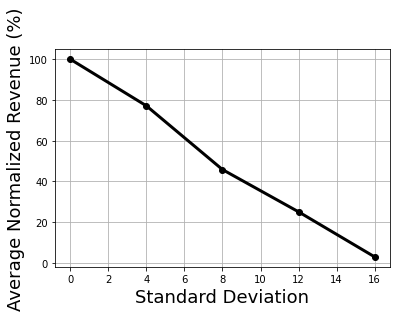

In [341]:
plt.plot(standard_deviation,Revenue_Std,'ko-',linewidth=3)
plt.xlabel('Standard Deviation',fontsize=18)
plt.ylabel('Average Normalized Revenue (%)',fontsize=18)
plt.grid(True)
plt.show()

**Discussion** What is the impact with the larger uncertainty?

=================================================

**Answer :**

By increasing the uncertainty, the value of the average normalized revenue decreases significantly. In this case, the standard devation was limited to the interval of $[0, 16]$. But as the trend shows, by increasing the standard devation to more than 16, the average revenue can also have the negative value.

**Discussion** Why does uncertainty in the price decrease the revenue (on average)?

=========================================================

**Answer :** 

I think the main reason for that is the choice of a prior which is the Gaussian distribution with mean equal to zero. This can result in negative uncertain random numbers which in general reduce the average normalized revenue.